In [107]:
from google.colab import drive
drive.mount('/drive')

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# First Example: 3-on-3 PHI (Home) vs. BOS (Away)

In [108]:
# Read in example data
ex_path = '../drive/MyDrive/data/Basketball/PM_APM_RAPM/example_pm_PHI_BOS.csv'
dfx = pd.read_csv(ex_path)

In [109]:
dfx

,Lineup,PHI,PHI.1,PHI.2,BOS,BOS.1,BOS.2,Begin Score (PHI-BOS),End Score (PHI-BOS),Change in Score differential
0,1,Embiid,Maxey,Harris,Tatum,Brown,Porzingis,0-0,21-15,6
1,2,Embiid,Maxey,Oubre Jr.,Tatum,Brown,Horford,21-15,22-27,-11
2,3,Embiid,Melton,Oubre Jr.,Tatum,Holiday,Horford,22-27,38-37,6
3,4,Harris,Maxey,Oubre Jr.,Brown,Holiday,Horford,38-37,55-60,-6
4,5,Harris,Maxey,Embiid,Brown,Porzingis,Tatum,55-60,75-68,12
5,6,Melton,Maxey,Embiid,Brown,Horford,Tatum,75-68,90-80,3
6,7,Melton,Harris,Embiid,Porzingis,Horford,Holiday,90-80,100-90,0
7,8,Oubre Jr.,Harris,Maxey,Porzingis,Brown,Tatum,100-90,105-107,-12
8,9,Embiid,Harris,Maxey,Porzingis,Holiday,Tatum,105-107,115-112,5


In [110]:
# Rename columns to make easier to work with
dfx = dfx.rename(columns={'PHI':'H1','PHI.1':'H2', 'PHI.2':'H3',
                          'BOS':'A1','BOS.1':'A2','BOS.2':'A3',
                          'Change in Score differential':'SD_delta',
                          'Lineup':'Stint'})

In [111]:
dfx

,Stint,H1,H2,H3,A1,A2,A3,Begin Score (PHI-BOS),End Score (PHI-BOS),SD_delta
0,1,Embiid,Maxey,Harris,Tatum,Brown,Porzingis,0-0,21-15,6
1,2,Embiid,Maxey,Oubre Jr.,Tatum,Brown,Horford,21-15,22-27,-11
2,3,Embiid,Melton,Oubre Jr.,Tatum,Holiday,Horford,22-27,38-37,6
3,4,Harris,Maxey,Oubre Jr.,Brown,Holiday,Horford,38-37,55-60,-6
4,5,Harris,Maxey,Embiid,Brown,Porzingis,Tatum,55-60,75-68,12
5,6,Melton,Maxey,Embiid,Brown,Horford,Tatum,75-68,90-80,3
6,7,Melton,Harris,Embiid,Porzingis,Horford,Holiday,90-80,100-90,0
7,8,Oubre Jr.,Harris,Maxey,Porzingis,Brown,Tatum,100-90,105-107,-12
8,9,Embiid,Harris,Maxey,Porzingis,Holiday,Tatum,105-107,115-112,5


In [112]:
# There are some extra spaces around player names, so lets try to get names all in the same format
dfx['H1'] = dfx['H1'].str.lower().str.strip()
dfx['H2'] = dfx['H2'].str.lower().str.strip()
dfx['H3'] = dfx['H3'].str.lower().str.strip()
dfx['A1'] = dfx['A1'].str.lower().str.strip()
dfx['A2'] = dfx['A2'].str.lower().str.strip()
dfx['A3'] = dfx['A3'].str.lower().str.strip()

In [113]:
# Extract sets of unique players for each team
phi_players = dfx[['H1','H2','H3']].stack().unique()
bos_players = dfx[['A1','A2','A3']].stack().unique()
print(f"PHI Players: {phi_players}")
print(f"BOS Players: {bos_players}")

# Create columns that combine all players for each team from a given stint (helps to work with later...)
dfx['phi_lineup'] = dfx[['H1','H2','H3']].apply(lambda x: '_'.join(x), axis=1)
dfx['bos_lineup'] = dfx[['A1','A2','A3']].apply(lambda x: '_'.join(x), axis=1)


PHI Players: ['embiid' 'maxey' 'harris' 'oubre jr.' 'melton']
BOS Players: ['tatum' 'brown' 'porzingis' 'horford' 'holiday']


In [114]:
dfx

,Stint,H1,H2,H3,A1,A2,A3,Begin Score (PHI-BOS),End Score (PHI-BOS),SD_delta,phi_lineup,bos_lineup
0,1,embiid,maxey,harris,tatum,brown,porzingis,0-0,21-15,6,embiid_maxey_harris,tatum_brown_porzingis
1,2,embiid,maxey,oubre jr.,tatum,brown,horford,21-15,22-27,-11,embiid_maxey_oubre jr.,tatum_brown_horford
2,3,embiid,melton,oubre jr.,tatum,holiday,horford,22-27,38-37,6,embiid_melton_oubre jr.,tatum_holiday_horford
3,4,harris,maxey,oubre jr.,brown,holiday,horford,38-37,55-60,-6,harris_maxey_oubre jr.,brown_holiday_horford
4,5,harris,maxey,embiid,brown,porzingis,tatum,55-60,75-68,12,harris_maxey_embiid,brown_porzingis_tatum
5,6,melton,maxey,embiid,brown,horford,tatum,75-68,90-80,3,melton_maxey_embiid,brown_horford_tatum
6,7,melton,harris,embiid,porzingis,horford,holiday,90-80,100-90,0,melton_harris_embiid,porzingis_horford_holiday
7,8,oubre jr.,harris,maxey,porzingis,brown,tatum,100-90,105-107,-12,oubre jr._harris_maxey,porzingis_brown_tatum
8,9,embiid,harris,maxey,porzingis,holiday,tatum,105-107,115-112,5,embiid_harris_maxey,porzingis_holiday_tatum


In [115]:
df_phi_pm = pd.DataFrame()

# Iterate over each PHI player
for player in phi_players:

  # From stint data frame, extract rows in which the player of interest occurs
  player_df = dfx[dfx['phi_lineup'].str.contains(player)]
  n_stints = len(player_df)

  # As PHI is the home team, simply sum up the corresponding change in score differentials
  player_pm = player_df['SD_delta'].sum()

  # Put into data frame to be concatenated
  new_data = pd.DataFrame({'player':[player],
                           'PM':[player_pm],
                           'n_stints': [n_stints]})
  df_phi_pm = pd.concat([df_phi_pm, new_data], ignore_index=True)

df_phi_pm.insert(0, 'Team', 'PHI')

In [116]:
df_phi_pm

,Team,player,PM,n_stints
0,PHI,embiid,21,7
1,PHI,maxey,-3,7
2,PHI,harris,5,6
3,PHI,oubre jr.,-23,4
4,PHI,melton,9,3


In [117]:
## Compute Raw Plus-Minus (PM) For Each Player

# Initialize PHI players data frame
df_phi_pm = pd.DataFrame()

# Iterate over each PHI player
for player in phi_players:

  # From stint data frame, extract rows in which the player of interest occurs
  player_df = dfx[dfx['phi_lineup'].str.contains(player)]
  n_stints = len(player_df)

  # As PHI is the home team, simply sum up the corresponding change in score differentials
  player_pm = player_df['SD_delta'].sum()

  # Put into data frame to be concatenated
  new_data = pd.DataFrame({'player':[player],
                           'PM':[player_pm],
                           'n_stints': [n_stints]})
  df_phi_pm = pd.concat([df_phi_pm, new_data], ignore_index=True)

df_phi_pm.insert(0, 'Team', 'PHI')


# Follow the same logic but for BOS players
df_bos_pm = pd.DataFrame()

for player in bos_players:

  player_df = dfx[dfx['bos_lineup'].str.contains(player)]
  n_stints = len(player_df)

  # As BOS is the away team, take the negative of the changes in score differentials and sum them up
  player_pm = -1*player_df['SD_delta'].sum()

  new_data = pd.DataFrame({'player':[player],
                           'PM':[player_pm],
                           'n_stints': [n_stints]})
  df_bos_pm = pd.concat([df_bos_pm, new_data], ignore_index=True)

df_bos_pm.insert(0, 'Team', 'BOS')

# Concatenate the two teams together
dfx_pm = pd.concat([df_phi_pm, df_bos_pm], ignore_index=True)

dfx_pm['PM_per_stint'] = dfx_pm['PM']/dfx_pm['n_stints']
dfx_pm

,Team,player,PM,n_stints,PM_per_stint
0,PHI,embiid,21,7,3.000000
1,PHI,maxey,-3,7,-0.428571
2,PHI,harris,5,6,0.833333
3,PHI,oubre jr.,-23,4,-5.750000
4,PHI,melton,9,3,3.000000
5,BOS,tatum,-9,7,-1.285714
6,BOS,brown,8,6,1.333333
7,BOS,porzingis,-11,5,-2.200000
8,BOS,horford,8,5,1.600000
9,BOS,holiday,-5,4,-1.250000


In [118]:
# Convert to our design matrix form
df1 = pd.get_dummies(dfx[['H1','H2','H3','A1','A2','A3']], prefix='', prefix_sep='')
df1

,embiid,harris,melton,oubre jr.,harris,maxey,melton,embiid,harris,maxey,...,porzingis,tatum,brown,holiday,horford,porzingis,holiday,horford,porzingis,tatum
0,1,0,0,0,0,1,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
5,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
6,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
7,0,0,0,1,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
8,1,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1


- As we can see here, each player has multiple columns.
- We want to only have a single column for each player.

In [119]:
# Method 1 - Groupby columns
df1a = df1.groupby(level=0, axis=1).max()

# Method 2 - Transpose our dataframe and then groupby by rows
df1b = df1.T.groupby(level=0).max().T

# Both of these methods should produce the exact same matrix (and therefore doesn't matter which you use)
df1a.eq(df1b)


,brown,embiid,harris,holiday,horford,maxey,melton,oubre jr.,porzingis,tatum
0,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True


In [120]:
df1a

,brown,embiid,harris,holiday,horford,maxey,melton,oubre jr.,porzingis,tatum
0,1,1,1,0,0,1,0,0,1,1
1,1,1,0,0,1,1,0,1,0,1
2,0,1,0,1,1,0,1,1,0,1
3,1,0,1,1,1,1,0,1,0,0
4,1,1,1,0,0,1,0,0,1,1
5,1,1,0,0,1,1,1,0,0,1
6,0,1,1,1,1,0,1,0,1,0
7,1,0,1,0,0,1,0,1,1,1
8,0,1,1,1,0,1,0,0,1,1


In [121]:
# Reorder
phi_cols = ['embiid','harris','maxey','melton','oubre jr.']
bos_cols = ['brown','holiday','horford','porzingis','tatum']

cols = phi_cols+bos_cols
df2 = df1a[cols]
df2

,embiid,harris,maxey,melton,oubre jr.,brown,holiday,horford,porzingis,tatum
0,1,1,1,0,0,1,0,0,1,1
1,1,0,1,0,1,1,0,1,0,1
2,1,0,0,1,1,0,1,1,0,1
3,0,1,1,0,1,1,1,1,0,0
4,1,1,1,0,0,1,0,0,1,1
5,1,0,1,1,0,1,0,1,0,1
6,1,1,0,1,0,0,1,1,1,0
7,0,1,1,0,1,1,0,0,1,1
8,1,1,1,0,0,0,1,0,1,1


In [122]:
# For the away players change the 1s to -1s
df2[bos_cols] = -1*df2[bos_cols]
df2

,embiid,harris,maxey,melton,oubre jr.,brown,holiday,horford,porzingis,tatum
0,1,1,1,0,0,-1,0,0,-1,-1
1,1,0,1,0,1,-1,0,-1,0,-1
2,1,0,0,1,1,0,-1,-1,0,-1
3,0,1,1,0,1,-1,-1,-1,0,0
4,1,1,1,0,0,-1,0,0,-1,-1
5,1,0,1,1,0,-1,0,-1,0,-1
6,1,1,0,1,0,0,-1,-1,-1,0
7,0,1,1,0,1,-1,0,0,-1,-1
8,1,1,1,0,0,0,-1,0,-1,-1


In [123]:
X = np.array(df2)

In [124]:
XtX = X.T @ X
DtD = df2.T @ df2

<Axes: >

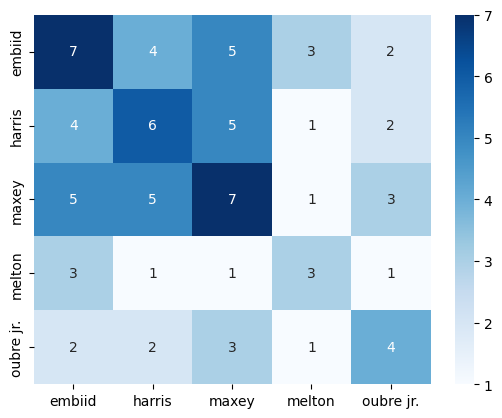

In [125]:
sns.heatmap(DtD.iloc[:5,:5], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

<Axes: >

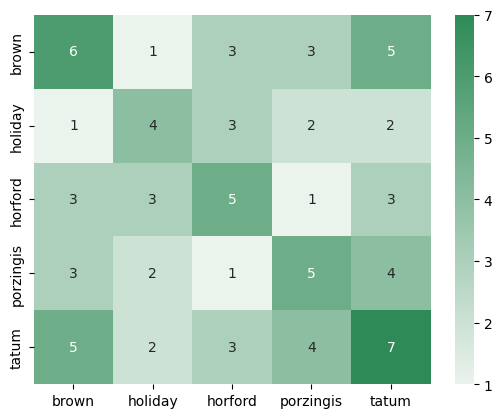

In [126]:
sns.heatmap(DtD.iloc[5:,5:], annot=True, cmap=sns.light_palette("seagreen", as_cmap=True))

<Axes: >

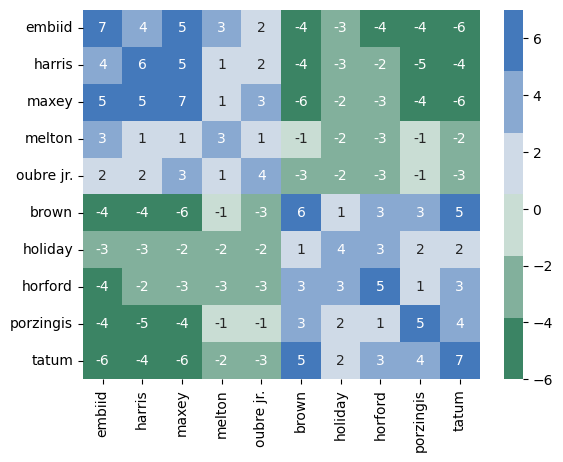

In [127]:
sns.heatmap(DtD, annot=True, cmap=sns.diverging_palette(150, 250))

## Adjusted Plus-Minus

### Dealing with Multicollinearity: Set one player's coefficient to 0
- Since Melton (on PHI) only played in 3 stints, let's set his coefficient to 0

In [128]:
# Recall that the simplest method to do this is to just remove his column in our design matrix
col_to_remove = df2.columns[3]
print(f"Column to Remove: {col_to_remove}")

Column to Remove: melton


In [129]:
df2_new = df2.drop(col_to_remove, axis=1)
X_new = np.array(df2_new)
X_new

array([[ 1,  1,  1,  0, -1,  0,  0, -1, -1],
       [ 1,  0,  1,  1, -1,  0, -1,  0, -1],
       [ 1,  0,  0,  1,  0, -1, -1,  0, -1],
       [ 0,  1,  1,  1, -1, -1, -1,  0,  0],
       [ 1,  1,  1,  0, -1,  0,  0, -1, -1],
       [ 1,  0,  1,  0, -1,  0, -1,  0, -1],
       [ 1,  1,  0,  0,  0, -1, -1, -1,  0],
       [ 0,  1,  1,  1, -1,  0,  0, -1, -1],
       [ 1,  1,  1,  0,  0, -1,  0, -1, -1]], dtype=int16)

In [130]:
XtX = X_new.T @ X_new
print(XtX.shape)
print(np.linalg.matrix_rank(XtX)) # not full rank --> not invertible even with our ols fix
print(np.linalg.cond(XtX)) # very large number --> numerically unstable
print(np.linalg.eigvals(XtX)) # final eigen value is 0 --> again not invertible

(9, 9)
8
8.938584746630154e+16
[3.40022618e+01 6.10207239e+00 4.99910635e+00 3.41608185e+00
 1.56026833e+00 7.01071698e-01 1.21272136e-01 9.78654214e-02
 1.02302900e-15]


- So, even though we tried one of our methods for dealing with multicollinearity, it still didn't work...

In [131]:
y = np.array(dfx['SD_delta']).reshape((-1,1))
y.shape

(9, 1)

In [132]:
beta_hat = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y
beta_hat

array([[  7.71428571],
       [-13.0625    ],
       [-20.26584928],
       [-13.12175325],
       [-30.125     ],
       [-26.59375   ],
       [ 19.65625   ],
       [  2.8125    ],
       [ -4.875     ]])

In [133]:
df2_new

,embiid,harris,maxey,oubre jr.,brown,holiday,horford,porzingis,tatum
0,1,1,1,0,-1,0,0,-1,-1
1,1,0,1,1,-1,0,-1,0,-1
2,1,0,0,1,0,-1,-1,0,-1
3,0,1,1,1,-1,-1,-1,0,0
4,1,1,1,0,-1,0,0,-1,-1
5,1,0,1,0,-1,0,-1,0,-1
6,1,1,0,0,0,-1,-1,-1,0
7,0,1,1,1,-1,0,0,-1,-1
8,1,1,1,0,0,-1,0,-1,-1


In [134]:
df_apm = pd.DataFrame()
df_apm['Player'] = df2_new.columns
df_apm['APM'] = beta_hat

In [135]:
df_apm

,Player,APM
0,embiid,7.714286
1,harris,-13.062500
2,maxey,-20.265849
3,oubre jr.,-13.121753
4,brown,-30.125000
5,holiday,-26.593750
6,horford,19.656250
7,porzingis,2.812500
8,tatum,-4.875000


# Example with Actual Game Data

In [136]:
stint_path = '../drive/MyDrive/data/Basketball/PM_APM_RAPM/nba_2223_season_stints.csv'
player_path = '../drive/MyDrive/data/Basketball/PM_APM_RAPM/nba_2223_player_table.csv'

dfs = pd.read_csv(stint_path)
dfp = pd.read_csv(player_path)

In [137]:
dfs.shape, dfp.shape

((32358, 9), (539, 2))

In [138]:
print(f"There are {dfs['game_id'].nunique()} games in our data. There are {1230-dfs['game_id'].nunique()} games missing.")

There are 1225 games in our data. There are 5 games missing.


In [139]:
dfp.head()

,player_id,player_name
0,1630173,Precious Achiuwa
1,203500,Steven Adams
2,1628389,Bam Adebayo
3,1630534,Ochai Agbaji
4,1630583,Santi Aldama


In [140]:
dfs.head()

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin
0,22200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571
1,22200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444
2,22200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000
3,22200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000
4,22200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333


In [141]:
dfp.head()

,player_id,player_name
0,1630173,Precious Achiuwa
1,203500,Steven Adams
2,1628389,Bam Adebayo
3,1630534,Ochai Agbaji
4,1630583,Santi Aldama


In [142]:
dfs.head()

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin
0,22200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571
1,22200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444
2,22200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000
3,22200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000
4,22200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333


In [148]:
dfs[['game_id', 'stint_id', 'home_lineup']] \
    .assign(home_lineup=lambda x: x['home_lineup'].str.split('_')) \
    .explode('home_lineup') \
    .assign(on_court=1) \
    .pivot_table(index=['game_id','stint_id'], columns='home_lineup', values='on_court', fill_value=0) \
    .reset_index()

home_lineup,game_id,stint_id,101108,1626145,1626149,1626153,1626156,1626157,1626158,1626159,...,203991,203992,203994,203999,204001,204060,204456,2544,2617,2738
0,22200001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22200001,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22200001,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22200001,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22200001,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32353,22201230,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32354,22201230,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32355,22201230,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32356,22201230,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
home_players_data = dfs[['game_id', 'stint_id', 'home_lineup']] \
    .assign(home_lineup=lambda x: x['home_lineup'].str.split('_')) \
    .explode('home_lineup') \
    .assign(on_court=1) \
    .pivot_table(index=['game_id', 'stint_id'], columns='home_lineup', values='on_court', fill_value=0) \
    .reset_index()


In [ ]:
home_players_data

home_lineup,game_id,stint_id,101108,1626145,1626149,1626153,1626156,1626157,1626158,1626159,...,203991,203992,203994,203999,204001,204060,204456,2544,2617,2738
0,22200001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22200001,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22200001,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22200001,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22200001,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32353,22201230,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32354,22201230,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32355,22201230,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32356,22201230,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(home_players_data.columns[3:]), len(set(home_players_data.columns[3:]))

(526, 526)

In [150]:
away_players_data = dfs[['game_id', 'stint_id', 'away_lineup']] \
    .assign(away_lineup=lambda x: x['away_lineup'].str.split('_')) \
    .explode('away_lineup') \
    .assign(on_court=-1) \
    .pivot_table(index=['game_id', 'stint_id'], columns='away_lineup', values='on_court', fill_value=0) \
    .reset_index()


In [ ]:
len(away_players_data.columns[3:]), len(set(away_players_data.columns[3:]))

(529, 529)

In [ ]:
len(set(away_players_data.columns[3:]) & set(home_players_data.columns[3:]))

517

In [ ]:
d1 = pd.DataFrame({'A': [1,2,3], 'B': [10,20,30], 'C':[100,200,300]})
d2 = pd.DataFrame({'A': [4,5,6], 'C':[400,500, 600], 'D': [1000, 2000, 3000]})
d = pd.concat([d1, d2], ignore_index=True)
d

,A,B,C,D
0,1,10.0,100,NaN
1,2,20.0,200,NaN
2,3,30.0,300,NaN
3,4,NaN,400,1000.0
4,5,NaN,500,2000.0
5,6,NaN,600,3000.0


In [ ]:
home_players_data.isna().sum().sum()

0

In [ ]:
away_players_data.isna().sum().sum()

0

In [ ]:
concatenated_data = pd.concat([home_players_data, away_players_data], ignore_index=True)
concatenated_data.head()

,game_id,stint_id,101108,1626145,1626149,1626153,1626156,1626157,1626158,1626159,...,1629663,1629735,1630296,1630644,1630649,1631214,1631220,1631309,1631367,1631495
0,22200001,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22200001,2,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22200001,3,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22200001,4,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22200001,5,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
concatenated_data

,game_id,stint_id,101108,1626145,1626149,1626153,1626156,1626157,1626158,1626159,...,1629663,1629735,1630296,1630644,1630649,1631214,1631220,1631309,1631367,1631495
0,22200001,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22200001,2,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22200001,3,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22200001,4,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22200001,5,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64711,22201230,18,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64712,22201230,19,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64713,22201230,20,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64714,22201230,21,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
concatenated_data.shape, home_players_data.shape, away_players_data.shape

((64716, 541), (32358, 529), (32358, 532))

In [ ]:
summarized_data = concatenated_data.groupby(['game_id', 'stint_id']) \
                  .agg('sum') \
                  .reset_index()

In [ ]:
summarized_data.shape

(32358, 541)

In [ ]:
summarized_data.head()

,game_id,stint_id,101108,1626145,1626149,1626153,1626156,1626157,1626158,1626159,...,1629663,1629735,1630296,1630644,1630649,1631214,1631220,1631309,1631367,1631495
0,22200001,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22200001,2,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22200001,3,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22200001,4,0,0,-1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22200001,5,0,0,-1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
summarized_data.isna().sum().sum()

0

In [ ]:
# Join back to contextual data
dfs2 = dfs.merge(summarized_data, how='left',on=['game_id','stint_id'])
dfs2.head()

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin,101108,...,1629663,1629735,1630296,1630644,1630649,1631214,1631220,1631309,1631367,1631495
0,22200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dfs2.head()

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin,101108,...,1629663,1629735,1630296,1630644,1630649,1631214,1631220,1631309,1631367,1631495
0,22200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#dfs2['target'] = (dfs2['home_points']-dfs2['away_points'])/dfs2['n_pos']*100 # point differential per 100 possessions

#player_dict = dict(zip(dfp['player_id'].astype('str'), dfp['player_name']))
#dfs2.rename(columns=player_dict, inplace=True)

In [ ]:
player_dict = dict(zip(dfp['player_id'].astype('str'), dfp['player_name']))
dfs2.rename(columns=player_dict, inplace=True)

In [ ]:
dfs2.head()

,game_id,stint_id,home_lineup,away_lineup,n_pos,home_points,away_points,minutes,margin,Chris Paul,...,Chris Silva,Braxton Key,Mac McClung,Stanley Umude,Alondes Williams,Dereon Seabron,Trevor Hudgins,Jacob Gilyard,Donovan Williams,target
0,22200002,1,201939_202691_203110_203952_1626172,2544_201566_201976_203076_1629022,14,5,2,2.70,21.428571,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.428571
1,22200002,2,201939_202691_203110_203952_1626172,2544_201566_203076_1629022_1630559,9,6,2,1.67,44.444444,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.444444
2,22200002,3,201939_203110_203952_1626172_1629673,2544_201566_203076_1629022_1630559,5,0,3,0.48,-60.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-60.000000
3,22200002,4,201939_203110_203952_1626172_1629673,2544_203076_1629022_1629134_1630559,5,5,1,0.78,80.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.000000
4,22200002,5,201939_203210_203952_1629673_1630164,2544_203076_1629022_1629134_1630559,9,3,6,1.52,-33.333333,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-33.333333


In [ ]:
dfs2

In [ ]:
d = pd.DataFrame({'min': [1,2,3,5,10], 'p1': [0,1,1,-1,0], 'p2': [1,1,1,0,0], 'p3':[0,-1,-1,1,-1]})
d

,min,p1,p2,p3
0,1,0,1,0
1,2,1,1,-1
2,3,1,1,-1
3,5,-1,0,1
4,10,0,0,-1


In [ ]:
dfp_mins = pd.DataFrame()
for col in dfs2.columns[9:]:
  df_player = dfs2.loc[:,['minutes',col]]
  df_player = df_player[df_player[col] != 0]
  player_mins = df_player['minutes'].sum()
  new_data = pd.DataFrame({'player': [col], 'total_minutes':[player_mins]})
  dfp_mins = pd.concat([dfp_mins, new_data], ignore_index=True)

In [ ]:
player_cols_to_keep = dfp_mins[dfp_mins['total_minutes']>300]['player']
stint_context = dfs2.columns[:9]
player_cols = dfs2.columns[9:]
cols_to_keep = list(stint_context)+list(player_cols_to_keep)

dfs3 = dfs2[cols_to_keep]

In [ ]:
reg_apm = sm.OLS(endog=dfs3.iloc[:,8], exog=dfs3.iloc[:,9:]).fit()

In [ ]:
print(reg_apm.summary())

                                 OLS Regression Results                                
Dep. Variable:                 margin   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              1.821
Date:                Thu, 28 Mar 2024   Prob (F-statistic):                    1.92e-21
Time:                        19:20:27   Log-Likelihood:                     -1.8328e+05
No. Observations:               32358   AIC:                                  3.674e+05
Df Residuals:                   31950   BIC:                                  3.708e+05
Df Model:                         408                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [ ]:
reg_apm.params.sort_values(ascending=False).head(25)

Nikola Jokic         23.087451
Jalen Brunson        22.495048
Miles McBride        17.317420
Derrick Rose         17.304107
Trae Young           16.811160
Joel Embiid          15.877900
DeAndre Jordan       14.161968
Pascal Siakam        13.230729
Immanuel Quickley    13.151263
Coby White           12.810962
Myles Turner         12.621975
Zion Williamson      12.265192
Anthony Davis        12.184873
Christian Koloko     12.028260
Jusuf Nurkic         11.971756
Charles Bassey       11.955998
Aaron Gordon         11.784450
Rodney McGruder      11.739885
Anthony Gill         10.738453
Cameron Johnson      10.617341
Kevin Love           10.608364
Harrison Barnes      10.499634
Zeke Nnaji           10.280096
Draymond Green       10.198064
Darius Garland       10.035339
dtype: float64

- Mostly suprising names with the most impact....
- All p-values are large ==> very high standard errors
- Cannot truly tell if a player has positive or negative impact

In [ ]:
X = dfs3.iloc[:,9:]
XtX = X.T @ X
print(X.shape)
print(XtX.shape)
print(np.linalg.cond(XtX))
print(np.linalg.matrix_rank(X))
print(np.linalg.eigvals(XtX).min())

(32358, 408)
(408, 408)
331.0201812588159
408
17.78122015157304


# Regularized Adjusted Plus-Minus (RAPM)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
lambdas = np.arange(start = 0, stop=20000, step=500) # 40 models
ridge_reg = Ridge(fit_intercept=False)
param_grid = {'alpha':lambdas}
grid_search = GridSearchCV(ridge_reg,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(dfs3.iloc[:,9:],dfs3['margin'])

GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False),
             param_grid={'alpha': array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
        4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
        9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000,
       13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500,
       18000, 18500, 19000, 19500])},
             scoring='neg_mean_squared_error')

In [ ]:
optimal_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {optimal_alpha}")

Optimal Alpha: 500


In [151]:
cv_results = grid_search.cv_results_

In [152]:
cv_results

{'mean_fit_time': array([1.02981687, 0.38161826, 0.51500301, 0.4637486 , 0.32305393,
        0.32602868, 0.35466347, 0.47841697, 0.96148257, 0.3874372 ,
        0.32581897, 0.31862421, 0.35473237, 0.32505326, 0.56750121,
        0.43920116, 0.3377326 , 0.38989725, 0.38499246, 0.34025545,
        0.42676558, 0.64719934, 0.57993107, 0.38969045, 0.37869105,
        0.35746427, 0.4297678 , 0.56741486, 0.3181469 , 0.37796807,
        0.34121337, 0.36741223, 0.30899105, 0.47884679, 0.46390562,
        0.31259723, 0.350811  , 0.3361403 , 0.335955  , 0.38254609]),
 'std_fit_time': array([1.27358814, 0.03197198, 0.10564004, 0.10234219, 0.01858885,
        0.02691625, 0.03247565, 0.13760782, 0.39836239, 0.02408505,
        0.02078376, 0.01031029, 0.04424175, 0.0208914 , 0.111907  ,
        0.1196201 , 0.02226728, 0.01649526, 0.01474526, 0.02050239,
        0.13567318, 0.02448884, 0.08753074, 0.01595913, 0.01084838,
        0.03467026, 0.1097349 , 0.03908803, 0.01491143, 0.02568344,
        0.022

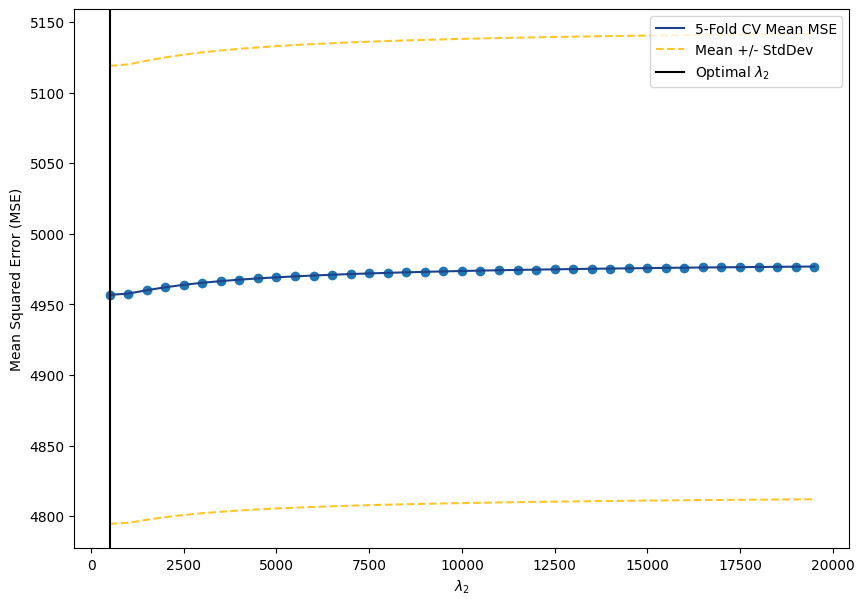

In [156]:
plt.figure(figsize=(10,7))
plt.scatter(lambdas[1:], -cv_results['mean_test_score'][1:])
plt.plot(lambdas[1:], -cv_results['mean_test_score'][1:], color='#1D428A', label='5-Fold CV Mean MSE')
plt.plot(lambdas[1:], -cv_results['mean_test_score'][1:]+cv_results['std_test_score'][1:], linestyle='dashed', color='#FFC72C', label='Mean +/- StdDev')
plt.plot(lambdas[1:], -cv_results['mean_test_score'][1:]-cv_results['std_test_score'][1:], linestyle='dashed', color='#FFC72C')
plt.axvline(x=optimal_alpha, color='black', label='Optimal $\lambda_2$')
plt.xlabel('$\lambda_2$')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(loc='best')

In [ ]:
-cv_results['mean_test_score']

array([7.74955488e+30, 4.95677238e+03, 4.95764743e+03, 4.96003537e+03,
       4.96213882e+03, 4.96387126e+03, 4.96530328e+03, 4.96650446e+03,
       4.96752746e+03, 4.96841059e+03, 4.96918192e+03, 4.96986236e+03,
       4.97046776e+03, 4.97101040e+03, 4.97149995e+03, 4.97194411e+03,
       4.97234912e+03, 4.97272009e+03, 4.97306128e+03, 4.97337621e+03,
       4.97366788e+03, 4.97393884e+03, 4.97419125e+03, 4.97442700e+03,
       4.97464771e+03, 4.97485480e+03, 4.97504950e+03, 4.97523293e+03,
       4.97540603e+03, 4.97556967e+03, 4.97572462e+03, 4.97587155e+03,
       4.97601108e+03, 4.97614375e+03, 4.97627007e+03, 4.97639049e+03,
       4.97650541e+03, 4.97661521e+03, 4.97672021e+03, 4.97682074e+03])

In [ ]:
np.sqrt(-cv_results['mean_test_score'])

array([2.78380224e+15, 7.04043491e+01, 7.04105633e+01, 7.04275186e+01,
       7.04424504e+01, 7.04547462e+01, 7.04649081e+01, 7.04734309e+01,
       7.04806886e+01, 7.04869534e+01, 7.04924246e+01, 7.04972507e+01,
       7.05015444e+01, 7.05053927e+01, 7.05088643e+01, 7.05120139e+01,
       7.05148858e+01, 7.05175162e+01, 7.05199353e+01, 7.05221682e+01,
       7.05242361e+01, 7.05261571e+01, 7.05279466e+01, 7.05296179e+01,
       7.05311825e+01, 7.05326506e+01, 7.05340308e+01, 7.05353311e+01,
       7.05365581e+01, 7.05377181e+01, 7.05388164e+01, 7.05398579e+01,
       7.05408469e+01, 7.05417873e+01, 7.05426826e+01, 7.05435361e+01,
       7.05443507e+01, 7.05451289e+01, 7.05458731e+01, 7.05465856e+01])

In [ ]:
final_ridge = Ridge(fit_intercept=False, alpha=500).fit(dfs3.iloc[:,9:],dfs2['margin'])

In [ ]:
print(f"R-Squared: {round(final_ridge.score(dfs3.iloc[:,9:],dfs3['margin']),2)}") # in-sample (training) R-Sq
print(f"MSE: {round(((final_ridge.predict(dfs3.iloc[:,9:])-dfs3['margin'])**2).mean(),2)}")
print(f"RMSE: {round(((final_ridge.predict(dfs3.iloc[:,9:])-dfs3['margin'])**2).mean()**.5,2)}")

R-Squared: 0.02
MSE: 4899.65
RMSE: 70.0


Text(0, 0.5, 'Actual Stint SD Per 100 Possessions')

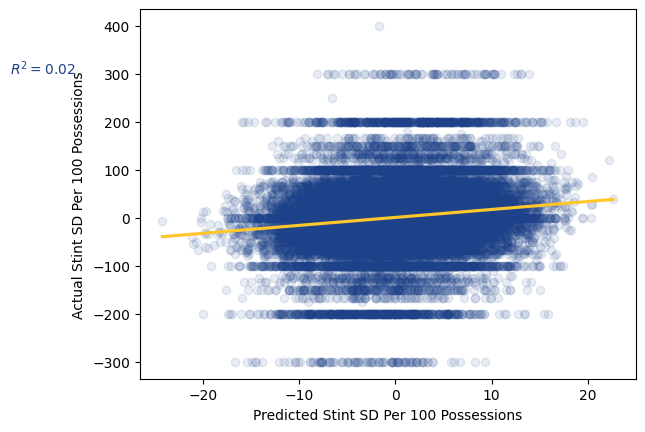

In [ ]:
sns.regplot(x=final_ridge.predict(dfs3.iloc[:,9:]), y=dfs3['margin'], scatter_kws={'color': '#1D428A', 'alpha':.1}, line_kws={'color': '#FFC72C'})
plt.text(-40, 300, f"$R^2 = {round(final_ridge.score(dfs3.iloc[:,9:],dfs3['margin']),2)}$", horizontalalignment='left', size='medium', color='#1D428A', weight='semibold')
#plt.text(-3, 4.5, f"Est. = {round(final_ridge_sm.params[0],2)} x Pred", horizontalalignment='left', size='medium', color='#1D428A')
plt.xlabel('Predicted Stint SD Per 100 Possessions')
plt.ylabel('Actual Stint SD Per 100 Possessions')

In [ ]:
df_rapm = pd.DataFrame()
df_rapm['reg_apm'] = reg_apm.params
df_rapm['reg_rapm'] = final_ridge.coef_
df_rapm['Player'] = dfs3.columns[9:]


In [ ]:
df_rapm.head()

,reg_apm,reg_rapm,Player
Chris Paul,6.436500,3.222127,Chris Paul
Tyus Jones,1.952589,-0.110329,Tyus Jones
Montrezl Harrell,1.512194,-1.474188,Montrezl Harrell
Delon Wright,6.723488,1.003949,Delon Wright
D'Angelo Russell,4.353079,1.978449,D'Angelo Russell


In [ ]:
df_rapm.shape

(408, 3)

In [ ]:
df_rapm.sort_values('reg_apm', ascending=False).head(15)

,reg_apm,reg_rapm,Player
Nikola Jokic,23.087451,6.050687,Nikola Jokic
Jalen Brunson,22.495048,4.864599,Jalen Brunson
Miles McBride,17.317420,1.484538,Miles McBride
Derrick Rose,17.304107,0.426672,Derrick Rose
Trae Young,16.811160,5.815508,Trae Young
Joel Embiid,15.877900,6.887348,Joel Embiid
DeAndre Jordan,14.161968,-0.222533,DeAndre Jordan
Pascal Siakam,13.230729,5.222697,Pascal Siakam
Immanuel Quickley,13.151263,2.618609,Immanuel Quickley
Coby White,12.810962,4.083044,Coby White


In [ ]:
df_rapm.sort_values('reg_rapm', ascending=False).head(15)

,reg_apm,reg_rapm,Player
Joel Embiid,15.877900,6.887348,Joel Embiid
Nikola Jokic,23.087451,6.050687,Nikola Jokic
Trae Young,16.811160,5.815508,Trae Young
Pascal Siakam,13.230729,5.222697,Pascal Siakam
Jalen Brunson,22.495048,4.864599,Jalen Brunson
Draymond Green,10.198064,4.617078,Draymond Green
Kevin Love,10.608364,4.611846,Kevin Love
Zion Williamson,12.265192,4.373720,Zion Williamson
Anthony Davis,12.184873,4.173047,Anthony Davis
Brook Lopez,9.222822,4.137109,Brook Lopez


- This at least passes the eye test quite a bit better...